##セッション内のいつ試行が起きているか

In [ ]:
# ===================================================================
# 共通セットアップセル (ローカル / Colab 共通)
# ===================================================================
import sys
import os
from pathlib import Path

# --- 1. 環境判別 ---
IN_COLAB = False
try:
    # Colab環境でのみインポートが成功する
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    pass # ローカル環境


if IN_COLAB:
    # ==================================
    # Colab 環境でのセットアップ
    # ==================================
    print("環境: Colab を検出。セットアップを開始します。")

    # 1. Google Driveのマウント
    drive.mount('/content/drive')

    # 2. GitHubリポジトリのクローンまたはプル
    repo_path = Path('/content/braidyn-bc')
    if repo_path.exists():
        print("リポジトリを pull します...")
        os.chdir(repo_path)
        !git pull
    else:
        print("リポジトリを clone します...")
        !git clone https://github.com/nyaamikeneko/braidyn-bc.git
        os.chdir(repo_path)

    # 3. 依存ライブラリのインストール
    print("依存ライブラリをインストールします...")
    !pip install -q pynwb git+https://github.com/BraiDyn-BC/bdbc-nwb-explorer.git

    # 4. sys.path の設定
    project_root = repo_path
    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

    print(f"セットアップ完了。プロジェクトルート: {project_root}")

else:
    # ==================================
    # ローカル (VSCode) 環境でのセットアップ
    # ==================================
    print("環境: ローカル (VSCode) を検出。")

    # 1. sys.path の設定
    current_dir = Path.cwd()
    if current_dir.name == 'notebooks':
        # ノートブックが notebooks/ から実行された場合
        project_root = current_dir.parent
    else:
        # プロジェクトルート (braidyn-bc/) から実行されたと仮定
        project_root = current_dir

    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

    print(f"プロジェクトルート: {project_root}")

# ===================================================================
# 共通インポート・処理
# (セットアップが完了したため、config.py や src/ が読み込める)
# ===================================================================
print("\n共通モジュールをインポートします...")

import bdbc_nwb_explorer as nwbx
import src.data_loader as dl
import config  # config.py もここで読み込める

print(f"データパス (DATA_NWB_ROOT): {config.DATA_NWB_ROOT}")

In [ ]:
# --- 必要なデータを関数で読み出す ---
SESSION_ID = "VG1GC-105"
NWB_FILENAME = "VG1GC-105_2024-02-02_task-day8.nwb"
TASK_DAY_DIR = "task-day8"

# NWBデータの読み込み
# (dl は共通セルでインポート済み)
session = dl.load_nwb_session(SESSION_ID, NWB_FILENAME)

# CSVデータの読み込み
trials = dl.load_trials_csv(SESSION_ID, TASK_DAY_DIR)

# これ以降、 session や trials を使った分析処理を記述...
if trials is not None:
    print(trials.head())

フィルタリング後の試行数: 200


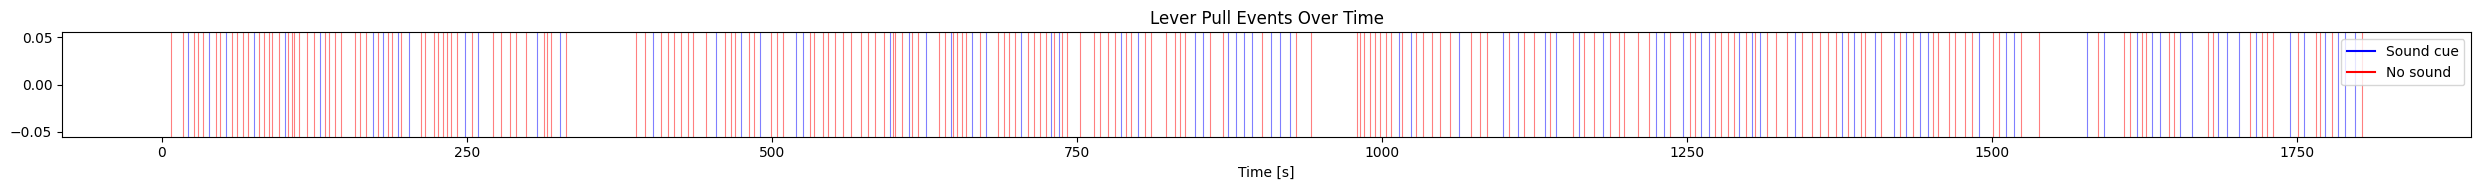

In [ ]:
import matplotlib.pyplot as plt

# 条件に合致する行のフィルタリング
filtered_trials = trials[(trials['state_lever']==1) &
                         (trials['state_task'] == 0) &
                         (trials['diff_value'] > 0.4)].copy()
print("フィルタリング後の試行数:", len(filtered_trials))

# lever_time_nocueの算出：tからdiff_valueを引いた時刻
filtered_trials['lever_time_nocue'] = filtered_trials['t'] - filtered_trials['diff_value']

filtered = trials.dropna(subset=['trial_outcome'])
filtered = filtered[
    (filtered['first_diff'] > 1.0) &
    (filtered['reaction_time'] > 0.091) &
    (filtered['reaction_time'] < 0.361)
].copy()

# --- 時間データ ---
sound_onsets = filtered['pull_onset']
no_sound_onsets = filtered_trials['lever_time_nocue']

# --- プロット ---
plt.figure(figsize=(25, 2))

# 音あり：縦線（青）
for t in sound_onsets:
    plt.axvline(t, color='blue', alpha=0.5, linewidth=0.8)

# 音なし：縦線（赤）
for t in no_sound_onsets:
    plt.axvline(t, color='red', alpha=0.5, linewidth=0.8)

# 凡例用のダミー線
plt.plot([], [], color='blue', label='Sound cue')
plt.plot([], [], color='red', label='No sound')

# 軸とラベル
plt.xlabel('Time [s]')
plt.title('Lever Pull Events Over Time')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


フィルタリング後の試行数: 200


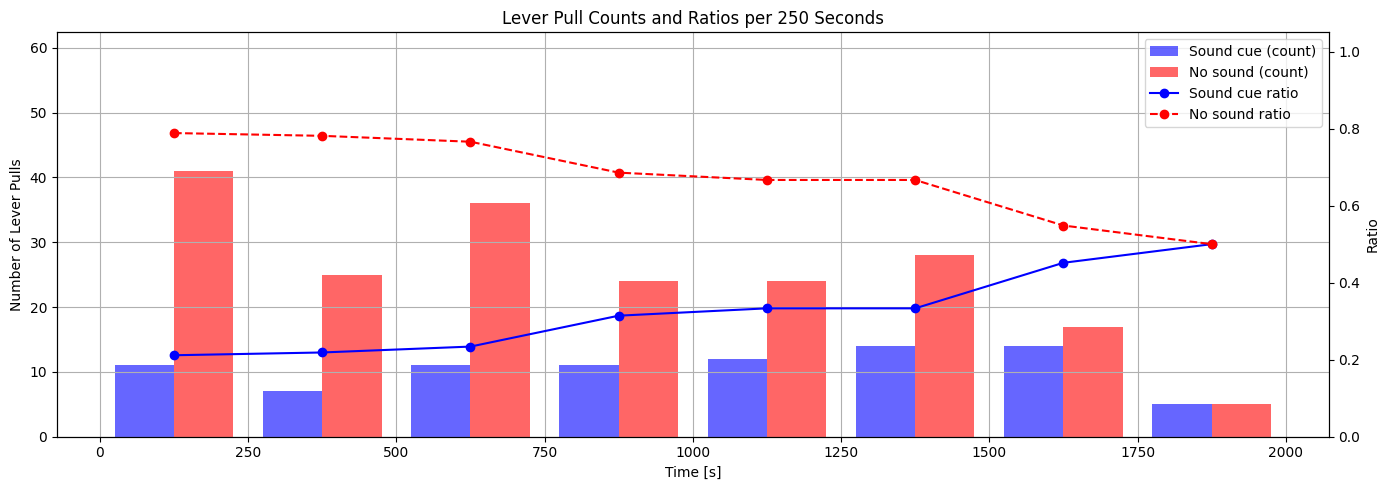

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# csv_path = Path('/content/drive/MyDrive/hackathon_data/VG1GC-53/task-day8/trials_L1L2.csv')
# trials = pd.read_csv(csv_path)
filtered_trials = trials[(trials['state_lever']==1) &
                         (trials['state_task'] == 0) &
                         (trials['diff_value'] > 0.4)].copy()
print("フィルタリング後の試行数:", len(filtered_trials))

# lever_time_nocueの算出：tからdiff_valueを引いた時刻
filtered_trials['lever_time_nocue'] = filtered_trials['t'] - filtered_trials['diff_value']


filtered = trials.dropna(subset=['trial_outcome'])
filtered = filtered[
    (filtered['first_diff'] > 1.0) &
    (filtered['reaction_time'] > 0.091) &
    (filtered['reaction_time'] < 0.361)
].copy()

# --- 時間データ ---
sound_onsets = filtered['pull_onset']
no_sound_onsets = filtered_trials['lever_time_nocue']

# --- パラメータ ---
bin_width = 250  # 秒
max_time = max(sound_onsets.max(), no_sound_onsets.max())
bins = np.arange(0, max_time + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2
width = bin_width * 0.4

# --- カウント ---
hist_sound, _ = np.histogram(sound_onsets, bins=bins)
hist_nosound, _ = np.histogram(no_sound_onsets, bins=bins)
total = hist_sound + hist_nosound

# --- 比率（割合） ---
ratio_sound = np.divide(hist_sound, total, out=np.zeros_like(hist_sound, dtype=float), where=total!=0)
ratio_nosound = np.divide(hist_nosound, total, out=np.zeros_like(hist_nosound, dtype=float), where=total!=0)

# --- プロット作成 ---
fig, ax1 = plt.subplots(figsize=(14, 5))

# --- 棒グラフ（回数） ---
ax1.bar(bin_centers - width/2, hist_sound, width=width, color='blue', alpha=0.6, label='Sound cue (count)')
ax1.bar(bin_centers + width/2, hist_nosound, width=width, color='red', alpha=0.6, label='No sound (count)')
ax1.set_ylabel('Number of Lever Pulls')
ax1.set_xlabel('Time [s]')
ax1.set_ylim(0, max(total)*1.2)

# --- 折れ線グラフ（割合） ---
ax2 = ax1.twinx()
ax2.plot(bin_centers, ratio_sound, marker='o', color='blue', linestyle='-', label='Sound cue ratio')
ax2.plot(bin_centers, ratio_nosound, marker='o', color='red', linestyle='--', label='No sound ratio')
ax2.set_ylabel('Ratio')
ax2.set_ylim(0, 1.05)

# --- 凡例とグリッド ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

ax1.grid(True)
plt.title('Lever Pull Counts and Ratios per 250 Seconds')
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/hackathon_data/VG1GC-48/task-day3/trials_L1L2.csv'

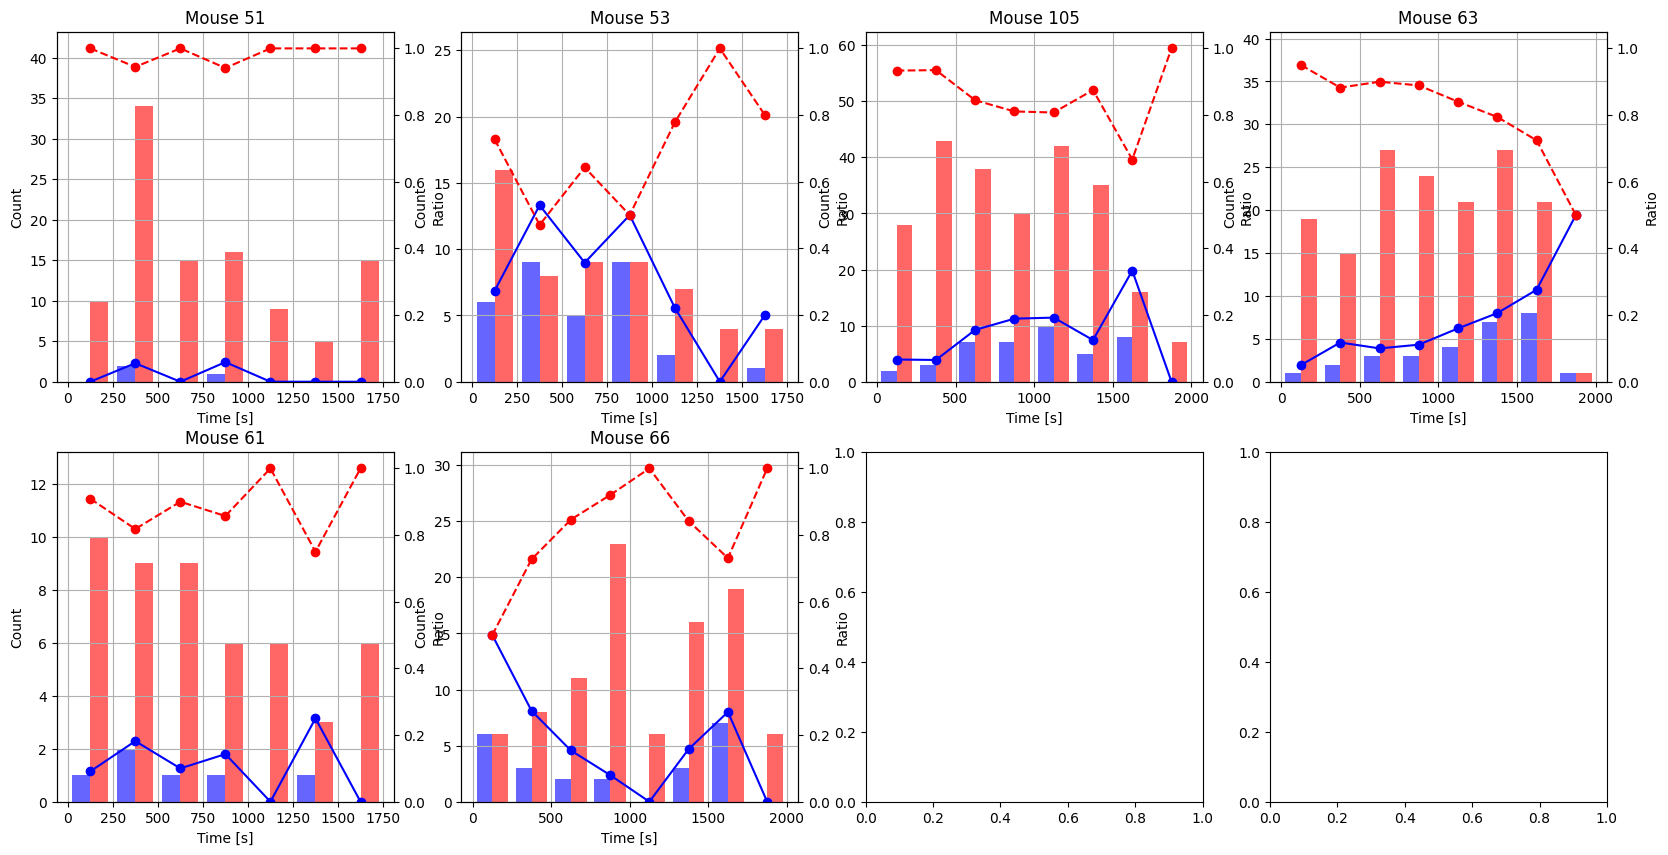

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === パラメータ設定 ===
mouse_ids = ["51", "53", "105", "63", "61", "66", "48"]
csv_root = Path('/content/drive/MyDrive/hackathon_data')
bin_width = 250  # 秒
width_ratio = 0.4

# === 図の設定 ===
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, mouse_id in enumerate(mouse_ids):
    # === データ読み込み ===
    csv_path = csv_root / f"VG1GC-{mouse_id}/task-day3/trials_L1L2.csv"
    trials = pd.read_csv(csv_path)

    # === 音なしレバー引き（diff_value > 0.4）===
    filtered_trials = trials[(trials['state_lever'] == 1) &
                             (trials['state_task'] == 0) &
                             (trials['diff_value'] > 0.4)].copy()
    filtered_trials['lever_time_nocue'] = filtered_trials['t'] - filtered_trials['diff_value']

    # === 音ありレバー引き（反応時間フィルタ）===
    filtered = trials.dropna(subset=['trial_outcome']).copy()
    filtered = filtered[
        (filtered['first_diff'] > 1.0) &
        (filtered['reaction_time'] > 0.091) &
        (filtered['reaction_time'] < 0.361)
    ].copy()

    sound_onsets = filtered['pull_onset']
    no_sound_onsets = filtered_trials['lever_time_nocue']

    # === ヒストグラム用のビン ===
    max_time = max(sound_onsets.max(), no_sound_onsets.max())
    bins = np.arange(0, max_time + bin_width, bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    width = bin_width * width_ratio

    # === カウントと比率計算 ===
    hist_sound, _ = np.histogram(sound_onsets, bins=bins)
    hist_nosound, _ = np.histogram(no_sound_onsets, bins=bins)
    total = hist_sound + hist_nosound
    ratio_sound = np.divide(hist_sound, total, out=np.zeros_like(hist_sound, dtype=float), where=total != 0)
    ratio_nosound = np.divide(hist_nosound, total, out=np.zeros_like(hist_nosound, dtype=float), where=total != 0)

    # === プロット ===
    ax1 = axes[i]
    ax2 = ax1.twinx()

    ax1.bar(bin_centers - width/2, hist_sound, width=width, color='blue', alpha=0.6)
    ax1.bar(bin_centers + width/2, hist_nosound, width=width, color='red', alpha=0.6)
    ax2.plot(bin_centers, ratio_sound, marker='o', color='blue', linestyle='-')
    ax2.plot(bin_centers, ratio_nosound, marker='o', color='red', linestyle='--')

    ax1.set_title(f"Mouse {mouse_id}")
    ax1.set_ylim(0, max(total) * 1.2)
    ax2.set_ylim(0, 1.05)
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Count')
    ax2.set_ylabel('Ratio')
    ax1.grid(True)

# 不要なプロット枠を非表示
for j in range(len(mouse_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Lever Pulls: Count and Ratio per 250s (Sound vs No-sound)', fontsize=16, y=1.02)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/hackathon_data/VG1GC-48/task-day3/trials_L1L2.csv'

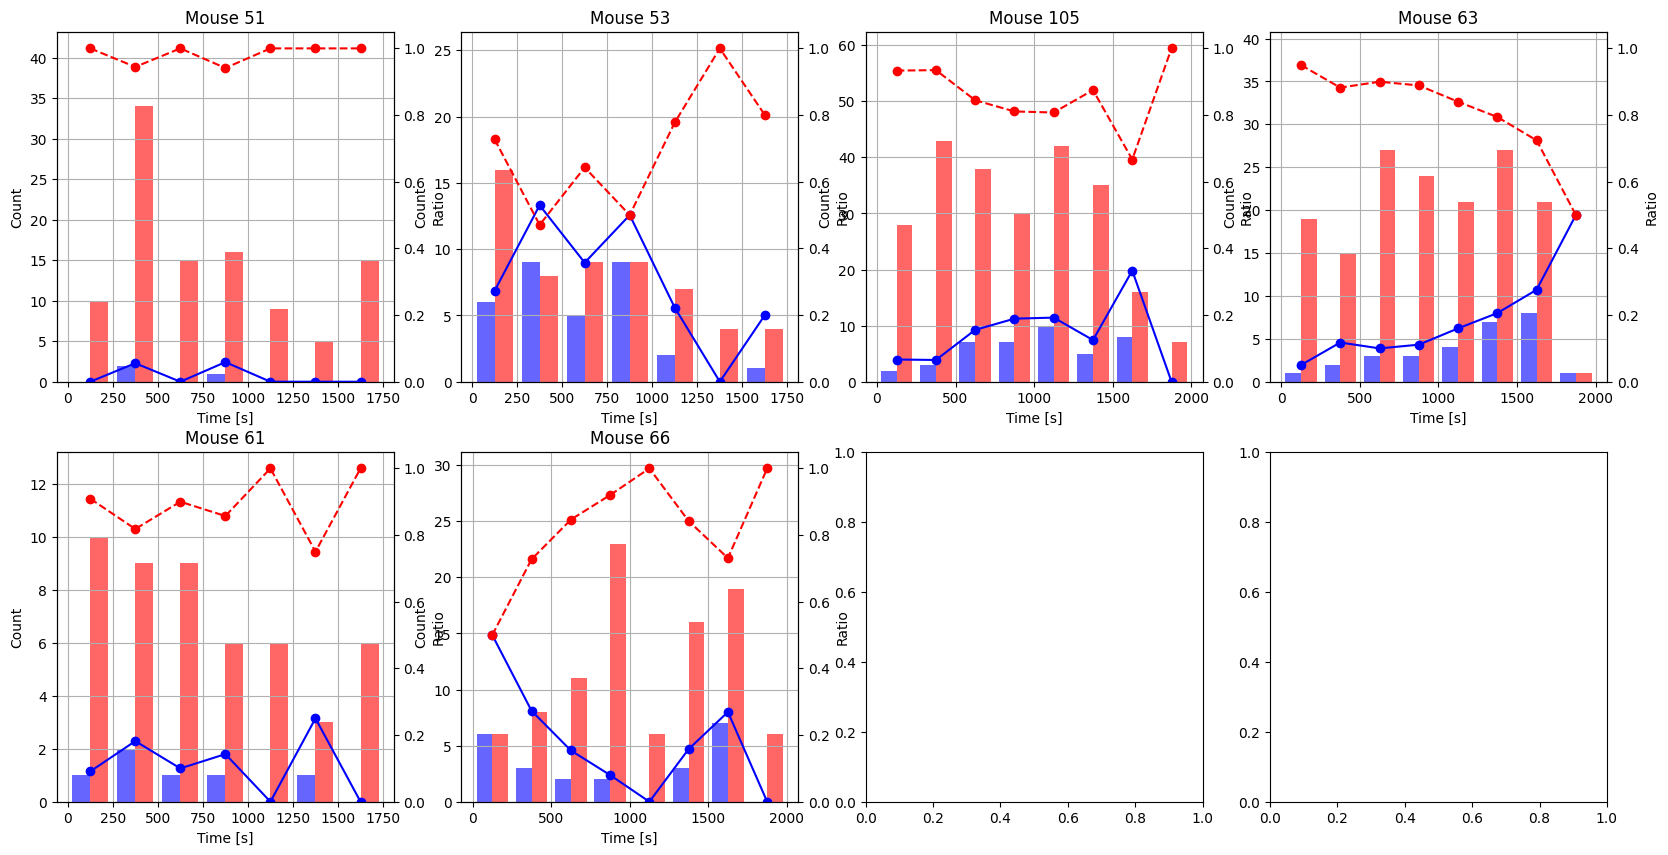

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === パラメータ設定 ===
mouse_ids = ["51", "53", "105", "63", "61", "66", "48"]
csv_root = Path('/content/drive/MyDrive/hackathon_data')
bin_width = 250  # 秒
width_ratio = 0.4

# === 図の設定 ===
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, mouse_id in enumerate(mouse_ids):
    # === データ読み込み ===
    csv_path = csv_root / f"VG1GC-{mouse_id}/task-day3/trials_L1L2.csv"
    trials = pd.read_csv(csv_path)

    # === 音なしレバー引き（diff_value > 0.4）===
    filtered_trials = trials[(trials['state_lever'] == 1) &
                             (trials['state_task'] == 0) &
                             (trials['diff_value'] > 0.4)].copy()
    filtered_trials['lever_time_nocue'] = filtered_trials['t'] - filtered_trials['diff_value']

    # === 音ありレバー引き（反応時間フィルタ）===
    filtered = trials.dropna(subset=['trial_outcome']).copy()
    filtered = filtered[
        (filtered['first_diff'] > 1.0) &
        (filtered['reaction_time'] > 0.091) &
        (filtered['reaction_time'] < 0.361)
    ].copy()

    sound_onsets = filtered['pull_onset']
    no_sound_onsets = filtered_trials['lever_time_nocue']

    # === ヒストグラム用のビン ===
    max_time = max(sound_onsets.max(), no_sound_onsets.max())
    bins = np.arange(0, max_time + bin_width, bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    width = bin_width * width_ratio

    # === カウントと比率計算 ===
    hist_sound, _ = np.histogram(sound_onsets, bins=bins)
    hist_nosound, _ = np.histogram(no_sound_onsets, bins=bins)
    total = hist_sound + hist_nosound
    ratio_sound = np.divide(hist_sound, total, out=np.zeros_like(hist_sound, dtype=float), where=total != 0)
    ratio_nosound = np.divide(hist_nosound, total, out=np.zeros_like(hist_nosound, dtype=float), where=total != 0)

    # === プロット ===
    ax1 = axes[i]
    ax2 = ax1.twinx()

    ax1.bar(bin_centers - width/2, hist_sound, width=width, color='blue', alpha=0.6)
    ax1.bar(bin_centers + width/2, hist_nosound, width=width, color='red', alpha=0.6)
    ax2.plot(bin_centers, ratio_sound, marker='o', color='blue', linestyle='-')
    ax2.plot(bin_centers, ratio_nosound, marker='o', color='red', linestyle='--')

    ax1.set_title(f"Mouse {mouse_id}")
    ax1.set_ylim(0, max(total) * 1.2)
    ax2.set_ylim(0, 1.05)
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Count')
    ax2.set_ylabel('Ratio')
    ax1.grid(True)

# 不要なプロット枠を非表示
for j in range(len(mouse_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Lever Pulls: Count and Ratio per 250s (Sound vs No-sound)', fontsize=16, y=1.02)
plt.show()


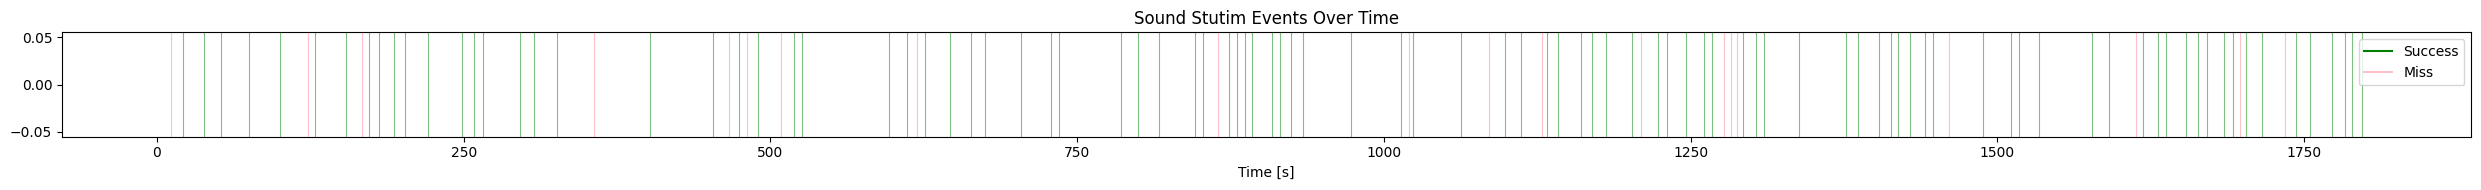

In [ ]:
import matplotlib.pyplot as plt

# --- データフレームの参照（仮） ---
# 適当にテストNWBファイルを選択
#dataroot = Path('/content/drive/MyDrive/braidyn-bc/data')
#testfile = dataroot / "VG1GC-105" / "VG1GC-105_2024-02-02_task-day8.nwb"
#session = nwbx.read_nwb(testfile)
df = session.trials.data

# --- 時間データ ---
trials_success = df[df['trial_outcome']=='success']['start_time']
trials_miss = df[df['trial_outcome']=='miss']['start_time']

# --- プロット ---
plt.figure(figsize=(25, 2))

# 音あり：縦線（青）
for t in trials_success:
    plt.axvline(t, color='green', alpha=0.5, linewidth=0.8)

# 音なし：縦線（赤）
for t in trials_miss:
    plt.axvline(t, color='pink', alpha=1, linewidth=0.8)

# 凡例用のダミー線
plt.plot([], [], color='green', label='Success')
plt.plot([], [], color='pink', label='Miss')

# 軸とラベル
plt.xlabel('Time [s]')
plt.title('Sound Stutim Events Over Time')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


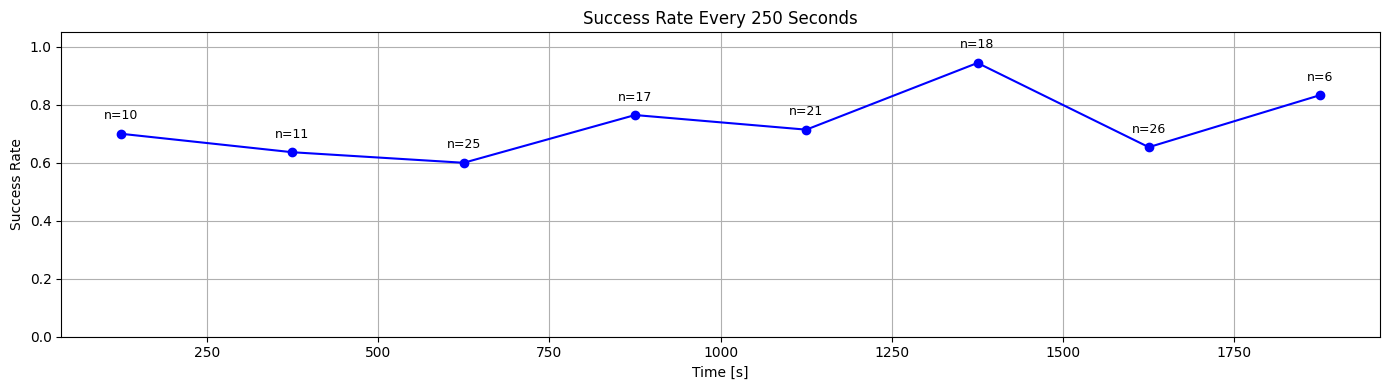

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# 適当にテストNWBファイルを選択
#dataroot = Path('/content/drive/MyDrive/braidyn-bc/data')
#testfile = dataroot / "VG1GC-105" / "VG1GC-105_2024-02-02_task-day8.nwb"
#session = nwbx.read_nwb(testfile)
session=nwbx.read_nwb('/content/drive/MyDrive/braidyn-bc/data/VG1GC-61/VG1GC-61_2023-06-26_task-day8.nwb')
df = session.trials.data
# --- データ準備 ---
bin_width = 250  # 秒
start_times = df['start_time'].values
max_time = start_times.max()

# --- 時間ビンの定義 ---
bins = np.arange(0, max_time + bin_width, bin_width)

# --- 成功率と試行数の計算 ---
success_rate = []
total_trials = []
bin_centers = []

for i in range(len(bins)-1):
    bin_start = bins[i]
    bin_end = bins[i+1]
    bin_center = (bin_start + bin_end) / 2
    bin_centers.append(bin_center)

    in_bin = df[(df['start_time'] >= bin_start) & (df['start_time'] < bin_end)]
    n_success = (in_bin['trial_outcome'] == 'success').sum()
    n_miss = (in_bin['trial_outcome'] == 'miss').sum()

    total = n_success + n_miss
    total_trials.append(total)

    rate = n_success / total if total > 0 else np.nan
    success_rate.append(rate)

# --- プロット ---
plt.figure(figsize=(14, 4))
plt.plot(bin_centers, success_rate, marker='o', color='blue')
plt.ylim(0, 1.05)
plt.xlabel('Time [s]')
plt.ylabel('Success Rate')
plt.title('Success Rate Every 250 Seconds')

# --- 試行数の数値を表示 ---
for x, y, total in zip(bin_centers, success_rate, total_trials):
    if not np.isnan(y):
        plt.text(x, y + 0.05, f'n={total}', ha='center', fontsize=9, color='black')

plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
trials_success

,start_time,stop_time,pull_onset,reaction_time,pull_duration_for_success,trial_outcome
2,21.545200,24.011801,21.711800,0.1742,0.3,success
3,38.245399,40.712002,38.411999,0.1398,0.3,success
4,52.045399,54.545399,52.245399,0.1918,0.3,success
5,74.778999,77.378998,75.079002,0.3104,0.3,success
6,100.612396,103.179199,100.879204,0.2522,0.3,success
...,...,...,...,...,...,...
158,1755.091187,1757.724609,1755.291260,0.2102,0.4,success
159,1772.824585,1775.391357,1772.991211,0.1832,0.4,success
160,1783.057983,1785.557983,1783.157959,0.1036,0.4,success
161,1789.157959,1791.824829,1789.424805,0.2582,0.4,success
